# Generación de *tarareos* sintéticos con TSGM VAE

**Alumno:** Elí Jafet Velásquez Luna

**Título del paper:** TSGM: A Flexible Framework for Generative
Modeling of Synthetic Time Series

**Autor:** Alexander Nikitin, Letizia Iannucci, Samuel Kaski



In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import re

## Análisis de datos

In [3]:
# Importar
df_midis_info = pd.read_csv('datos_procesados/midis/midis_info.csv')
df_midis_notas = pd.read_csv('datos_procesados/midis/midis_notas.csv', index_col=0)

new_cols = {col:re.findall(r'\((.*?)\)',col)[0] for col in df_midis_notas.columns}
df_midis_notas = df_midis_notas.rename(columns=new_cols)
notas_freq = df_midis_notas.sum()

El proyecto final (del diplomado) consiste en transcribir *tarareos* (imitar melodías sin articular bien las palabras) a mensajes MIDI. El problema se dividió en dos partes:

- **Detección de onsets (ataques de nota)**: Se resolvió con una arquitectura ConSeq2Seq que es un sistema encoder-decoder con capas LSTM cada una y una capa Convolucional + Max pooling en el inicio para la extracción de características.
- Detección de tono: El problema se planteó a resolver con un algoritmo de clústering sencillo como K-medias debido a la separación natural de tonos en el espectrograma.

El objetivo era que el sistema fuera lo menos sesgado posible en cuanto a *tesituras de voz*, para que los resultados fueran generalizables. Sin embargo, hay algunas tesituras cuyo espectro de notas cubierto es sesgado o limitado:

C:\Users\Jafet Velásquez Luna\AppData\Local\Temp\ipykernel_38416\4218046743.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('cividis', len(tesituras))


Muestras en bajo:  234726
Muestras en baritono:  295433
Muestras en tenor:  336392
Muestras en alto:  353632
Muestras en mezzo:  334254
Muestras en soprano:  291217


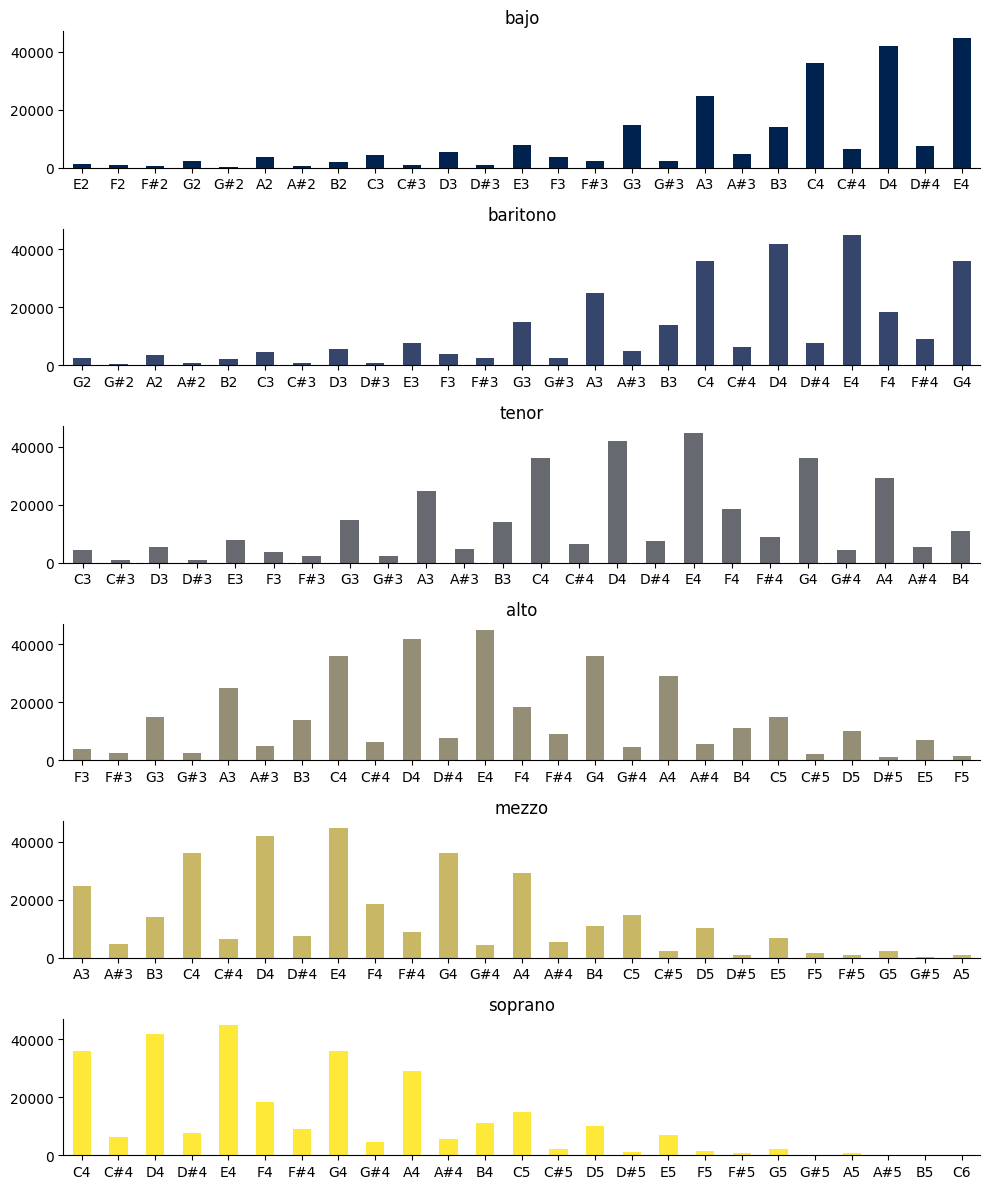

In [4]:
tesituras = {
    'bajo': notas_freq.loc['E2':'E4'],
    'baritono': notas_freq.loc['G2':'G4'],
    'tenor': notas_freq.loc['C3':'B4'],
    'alto': notas_freq.loc['F3':'F5'],
    'mezzo': notas_freq.loc['A3':'A5'],
    'soprano': notas_freq.loc['C4':'C6']
}

fig, axs = plt.subplots(6,1, figsize=(10, 2*6))


cmap = cm.get_cmap('cividis', len(tesituras))
norm = mcolors.Normalize(vmin=0, vmax=5)


for (i,ax), (rango,freqs) in zip(enumerate(axs), tesituras.items()):
    color = cmap(norm(i))
    print(f'Muestras en {rango}: ', freqs.sum())

    ax.set_title(rango)
    ax.spines[[ 'top', 'right']].set_visible(False)
    freqs.plot(kind='bar', ax=ax, color=color)
    ax.tick_params(axis='x', labelrotation=0)

fig.tight_layout()

Si bien tienen un número de notas similar en su distribución. Hay algunas que tienen menos frecuencia en algunas notas, como es el caso del *baritono* o *soprano*.

Es por ello que generar datos artificiales para cubrir el espectro completo puede ser benéfico para la generalización del sistema.

En este caso, analizaremos la **tesitura baritono**.

In [5]:
import pandas as pd

# Supongamos que tienes un DataFrame llamado df y una lista de columnas preferidas
columnas_preferidas = tesituras['baritono'].index

# Filtrar filas donde al menos una de las columnas preferidas tiene un valor mayor que 0
filtro_preferidas = (df_midis_notas[columnas_preferidas] > 0).any(axis=1)

# Filtrar filas donde las demás columnas tienen valores iguales a 0
otras_columnas = df_midis_notas.columns.difference(columnas_preferidas)
filtro_otras = (df_midis_notas[otras_columnas] == 0).all(axis=1)

# Aplicar ambos filtros
df_filtrado = df_midis_notas[filtro_preferidas & filtro_otras]

df_filtrado = df_filtrado[tesituras['baritono'].index]
df_filtrado

,G2,G#2,A2,A#2,B2,C3,C#3,D3,D#3,E3,...,A#3,B3,C4,C#4,D4,D#4,E4,F4,F#4,G4
key,,,,,,,,,,,,,,,,,,,,,
F01_0003_0001_1_D,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,4,0,4,4,0,3
F01_0003_0001_2_D,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,4,0,4,4,0,3
F01_0007_0001_1,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,6,0,6,6,0,4
F01_0007_0001_2,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,6,0,6,6,0,4
F01_0008_0001_1,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,4,0,6,4,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M05_0422_0001_2,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,10,0,6,6,0,2
M05_0426_0001_1,0,0,0,0,0,0,0,0,0,0,...,5,0,4,0,6,5,0,4,0,0
M05_0426_0001_2,0,0,0,0,0,0,0,0,0,0,...,5,0,4,0,6,5,0,4,0,0


En el `DataFrame` anterior se filtraron aquellas grabaciones que tienen notas sólo en la tesitura *baritono*. A continuación se filtran aquellas que no tienen notas por debajo de una cota definida como $\mu - \sigma$.

In [6]:
df_baritono = df_filtrado.copy()
notes_dict = {n+1:note for n,note in enumerate(df_baritono.columns)}
df_baritono.columns = list(range(1, len(df_baritono.columns)+1))

# Estadísticos de la tesitura baritono
mean = (df_baritono.sum() * df_baritono.sum().index).sum() / df_baritono.sum().sum()
std = (((df_baritono.sum().index - mean)**2 * df_baritono.sum()).sum() / df_baritono.sum().sum()) **0.5

# Filtrar aquellos sin notas en la cola
needed_columns = df_baritono.columns[:int(mean - std)]
mask_baritono_tail = (df_baritono[needed_columns] > 0).any(axis=1)
df_baritono_tail = df_baritono[mask_baritono_tail]
df_baritono_tail

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
key,,,,,,,,,,,,,,,,,,,,,
F01_0048_0001_1_D,0,0,0,0,0,0,0,0,0,1,...,0,2,0,4,7,0,7,0,5,2
F01_0048_0001_2_D,0,0,0,0,0,0,0,0,0,1,...,0,2,0,4,7,0,7,0,5,2
F01_0071_0001_1_D,0,0,0,0,0,2,0,0,0,6,...,0,8,7,0,6,4,9,1,0,0
F01_0071_0001_2_D,0,0,0,0,0,2,0,0,0,6,...,0,8,7,0,6,4,9,1,0,0
F01_0071_0002_1_D,0,0,0,0,0,2,0,0,0,5,...,0,6,4,0,2,4,6,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M05_0247_0001_1_D,0,0,0,0,0,2,0,2,0,5,...,0,0,1,0,0,0,0,0,0,0
M05_0251_0001_1_D,0,0,0,0,0,0,0,1,0,2,...,0,2,5,0,2,0,2,1,0,0
M05_0408_0001_2_D,0,0,0,0,0,0,0,0,1,0,...,1,6,0,3,0,2,0,0,0,0


In [7]:
import shutil
import os

# Directorios de origen y destino
origen = 'datos/Tarareos/wav_data_sync_with_midi/'
destino = 'VAE_tarareos/'

# Asegúrate de que el directorio de destino exista
os.makedirs(destino, exist_ok=True)

# Mover archivos
for archivo in df_baritono_tail.index:
    shutil.copy(os.path.join(origen, archivo+'.wav'), os.path.join(destino, archivo+'.wav'))

print("Archivos movidos exitosamente.")

Archivos movidos exitosamente.


## Time series generation using VAEs
This is a minimal example of unsupervised time series generation using VAEs.

In [8]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import sklearn
import copy
import sklearn.model_selection
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tsgm

ModuleNotFoundError: No module named 'wrapt.patches'

#### 1. Choose architecture of encoder and decoder.
Here, you can either use one of the architectures presented in `tsgm.models.architectures`, or define custom discriminator and generator architectures as `keras` models.

In [ ]:
architecture = tsgm.models.zoo["vae_conv5"](24, 5, 10)
encoder, decoder = architecture.encoder, architecture.decoder

#### 2. Load data:
We are working with a toy dataset, and use `tsgm` utility called `tsgm.utils.gen_sine_dataset` to generate the data. Next, we feature-wise scale the dataset so that each feature is in $[0, 1]$, using `tsgm.utils.TSFeatureWiseScaler`.

In [ ]:
data = tsgm.utils.gen_sine_dataset(10000, 24, 5)
scaler = tsgm.utils.TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(data)

#### 3. Define model and train it.
We define a conditional GAN model (`tsgm.models.cvae.BetaVAE`), compile it, and train using `.fit` model.

In [ ]:
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(scaled_data, epochs=100, batch_size=64)

#### 4. Check reconstruction of the data.
We reconstruct data using `vae.predict(scaled_data)`. For validating that VAE works, we check that the original and reconstructed datasets are visually similar using `tsgm.utils.visualize_original_and_reconst_ts`.

In [ ]:
x_decoded = vae.predict(scaled_data)

In [ ]:
tsgm.utils.visualize_original_and_reconst_ts(scaled_data, x_decoded, num=10)